## Installation

In [ ]:
# We assume that you are working on CoLab. This code works on Python 3.7.
# You may change the version of PyTorch/XLA and other packages depending on your
# python version.
!pip install -q torch==1.9.0 torchtext torchvision pytorch_lightning
!pip install -q cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

!pip install -q transformers==4.15 transformers["ja"] datasets==1.18

# You can ignore pip's dependency error on torchaudio and earthengine-api. They
# won't be used.

In [ ]:
import os

if not os.environ.get('COLAB_TPU_ADDR'):
    print('Make sure to select TPU from Edit > Notebook settings > Hardware accelerator')

## Define model

In [2]:
import os
import string
import unicodedata
from typing import Any, Dict, Iterator, List, Tuple, Union

import datasets
import numpy as np
from pytorch_lightning import LightningModule, Trainer, seed_everything
import torch
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, AdamW

In [ ]:
args = {
    'random_seed': 42,  # Random Seed
    # Transformers PLM name.
    'pretrained_model': 'cl-tohoku/bert-base-japanese-whole-word-masking',
    # Optional, Transformers Tokenizer name. Overrides `pretrained_model`
    'pretrained_tokenizer': '',
    'norm_form': 'NFKC',
    'batch_size': 32,  # <=32 for TPUv2-8
    'lr': 2e-5,  # Learning Rate
    'max_length': 384,  # Max Length input size
    'doc_stride': 128,  # The interval of the context when splitting is needed
    'epochs': 4,  # Max Epochs
    'dataset': 'SkelterLabsInc/JaQuAD',
    'huggingface_auth_token': None,
    'test_mode': False,  # Test Mode enables `fast_dev_run`
    'optimizer': 'AdamW',
    'weight_decay': 0.01,  # Weight decaying parameter for AdamW
    'lr_scheduler': 'warmup_lin',
    'warmup_ratio': 0.1,
    'fp16': False,  # Enable train on FP16 (if GPU)
    'tpu_cores': 8,  # Enable TPU with 1 core or 8 cores
    'cpu_workers': os.cpu_count(),
}

args

{'batch_size': 32,
 'cpu_workers': 2,
 'dataset': 'SkelterLabsInc/JaQuAD',
 'huggingface_auth_token': None,
 'doc_stride': 128,
 'epochs': 4,
 'fp16': False,
 'lr': 2e-05,
 'lr_scheduler': 'warmup_lin',
 'max_length': 384,
 'norm_form': 'NFKC',
 'optimizer': 'AdamW',
 'pretrained_model': 'cl-tohoku/bert-base-japanese-whole-word-masking',
 'pretrained_tokenizer': '',
 'random_seed': 42,
 'test_mode': False,
 'tpu_cores': 8,
 'warmup_ratio': 0.1,
 'weight_decay': 0.01}

In [ ]:
class WarmupLinearLR(lr_scheduler.LambdaLR):
    '''The learning rate is linearly increased for the first `warmup_steps`
    and linearly decreased to zero afterward.
    '''

    def __init__(self, optimizer, warmup_steps, max_steps, last_epoch=-1):

        def lr_lambda(step):
            if step < warmup_steps:
                return float(step) / float(max(1.0, warmup_steps))
            ratio = 1 - float(step - warmup_steps) / float(max_steps -
                                                           warmup_steps)
            return max(0.0, min(1.0, ratio))

        super().__init__(optimizer, lr_lambda, last_epoch=last_epoch)

In [ ]:
def make_spans(
    inputs: Dict[str, Union[int, List[int]]],
    question_len: int,
    max_seq_len: int,
    stride: int,
    answer_start_position: int = -1,
    answer_end_position: int = -1
) -> Iterator[Tuple[Dict[str, List[int]], Tuple[int, int]]]:
    input_len = len(inputs['input_ids'])
    context_len = input_len - question_len

    def make_value(input_list, i, padding=0):
        context_end = min(max_seq_len - question_len, context_len - i)
        pad_len = max_seq_len - question_len - context_end
        val = input_list[:question_len]
        val += input_list[question_len + i:question_len + i + context_end]
        val[-1] = input_list[-1]
        val += [padding] * pad_len
        return val

    for i in range(0, input_len - max_seq_len + stride, stride):
        span = {key: make_value(val, i) for key, val in inputs.items()}
        answer_start = answer_start_position - i
        answer_end = answer_end_position - i
        if answer_start < question_len or answer_end >= max_seq_len - 1:
            answer_start = answer_end = 0
        yield span, (answer_start, answer_end)

In [3]:
def get_offsets(input_ids: List[int],
                context: str,
                tokenizer: AutoTokenizer,
                norm_form='NFKC') -> List[Tuple[int, int]]:
    '''The character-level start/end offsets of a token within a context.
    Algorithm:
    1. Make offsets of normalized context within the original context.
    2. Make offsets of tokens (input_ids) within the normalized context.

    Arguments:
    input_ids -- Token ids of tokenized context (by tokenizer).
    context -- String of context
    tokenizer
    norm_form

    Return:
        List[Tuple[int, int]]: Offsets of tokens within the input context.
        For each token, the offsets are presented as a tuple of (start
        position index, end position index). Both indices are inclusive.
    '''
    cxt_start = input_ids.index(tokenizer.sep_token_id) + 1
    cxt_end = cxt_start + input_ids[cxt_start:].index(tokenizer.sep_token_id)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[cxt_start:cxt_end])
    tokens = [tok[2:] if tok.startswith('##') else tok for tok in tokens]
    whitespace = string.whitespace + '\u3000'

    # 1. Make offsets of normalized context within the original context.
    offsets_norm_context = []
    norm_context = ''
    for idx, char in enumerate(context):
        norm_char = unicodedata.normalize(norm_form, char)
        norm_context += norm_char
        offsets_norm_context.extend([idx] * len(norm_char))
    norm_context_org = unicodedata.normalize(norm_form, context)
    assert norm_context == norm_context_org, \
        'Normalized contexts are not the same: ' \
        + f'{norm_context} != {norm_context_org}'
    assert len(norm_context) == len(offsets_norm_context), \
        'Normalized contexts have different numbers of tokens: ' \
        + f'{len(norm_context)} != {len(offsets_norm_context)}'

    # 2. Make offsets of tokens (input_ids) within the normalized context.
    offsets_token = []
    unk_pointer = None
    cid = 0
    tid = 0
    while tid < len(tokens):
        cur_token = tokens[tid]
        if cur_token == tokenizer.unk_token:
            unk_pointer = tid
            offsets_token.append([cid, cid])
            cid += 1
        elif norm_context[cid:cid + len(cur_token)] != cur_token:
            # Wrong offsets of the previous UNK token
            assert unk_pointer is not None, \
                'Normalized context and tokens are not matched'
            prev_unk_expected = offsets_token[unk_pointer]
            prev_unk_expected[1] += norm_context[prev_unk_expected[1] + 2:]\
                .index(tokens[unk_pointer + 1]) + 1
            tid = unk_pointer
            offsets_token = offsets_token[:tid] + [prev_unk_expected]
            cid = prev_unk_expected[1] + 1
        else:
            start_pos = norm_context[cid:].index(cur_token)
            if start_pos > 0 and tokens[tid - 1] == tokenizer.unk_token:
                offsets_token[-1][1] += start_pos
                cid += start_pos
                start_pos = 0
            assert start_pos == 0, f'{start_pos} != 0 (cur: {cur_token}'
            offsets_token.append([cid, cid + len(cur_token) - 1])
            cid += len(cur_token)
            while cid < len(norm_context) and norm_context[cid] in whitespace:
                offsets_token[-1][1] += 1
                cid += 1
        tid += 1
    if tokens[-1] == tokenizer.unk_token:
        offsets_token[-1][1] = len(norm_context) - 1
    else:
        assert cid == len(norm_context) == offsets_token[-1][1] + 1, \
            'Offsets do not include all characters'
    assert len(offsets_token) == len(tokens), \
        'The numbers of tokens and offsets are different'

    offsets_mapping = [(offsets_norm_context[start], offsets_norm_context[end])
                       for start, end in offsets_token]
    return [(-1, -1)] * cxt_start + offsets_mapping

In [ ]:
class QAModel(LightningModule):
    def __init__(self, **kwargs):
        super().__init__()
        self.save_hyperparameters()  # kwargs are saved in self.hparams
        self.automatic_optimization = False

        self.question_answerer = AutoModelForQuestionAnswering.from_pretrained(
            self.hparams.pretrained_model,
            use_auth_token=self.hparams.huggingface_auth_token)
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.hparams.pretrained_tokenizer
            if self.hparams.pretrained_tokenizer else
            self.hparams.pretrained_model,
            use_auth_token=self.hparams.huggingface_auth_token)

    def forward(self, **kwargs):
        return self.question_answerer(**kwargs)

    def step(self, batch, batch_idx):
        outputs = self(**batch)

        loss = outputs.loss
        start_preds = outputs.start_logits.argmax(dim=-1).cpu().detach()
        end_preds = outputs.end_logits.argmax(dim=-1).cpu().detach()
        start_positions = batch['start_positions'].cpu().detach()
        end_positions = batch['end_positions'].cpu().detach()

        return {
            'loss': loss,
            'start_preds': start_preds,
            'end_preds': end_preds,
            'start_positions': start_positions,
            'end_positions': end_positions,
        }

    def training_step(self, batch, batch_idx):
        opt = self.optimizers()
        opt.zero_grad()
        outputs = self.step(batch, batch_idx)
        self.manual_backward(outputs['loss'])
        opt.step()

        # single scheduler
        sch = self.lr_schedulers()
        sch.step()
        return outputs

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx)

    @staticmethod
    def calculate_f1_score(start_positions, end_positions, start_preds,
                           end_preds):
        start_overlap = np.maximum(start_positions, start_preds)
        start_overlap = np.maximum(start_positions, start_preds)
        end_overlap = np.minimum(end_positions, end_preds)
        overlap = np.maximum(end_overlap - start_overlap + 1, 0)

        pred_token_count = np.maximum(end_preds - start_preds + 1, 0)
        ground_token_count = np.maximum(end_positions - start_positions + 1, 0)

        precision = torch.nan_to_num(overlap / pred_token_count, nan=0.)
        recall = torch.nan_to_num(overlap / ground_token_count, nan=0.)
        f1 = torch.nan_to_num(
            2 * precision * recall / (precision + recall), nan=0.)
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    @staticmethod
    def calculate_exact_match(start_positions, end_positions, start_preds,
                              end_preds):
        equal_start = (start_preds == start_positions)
        equal_end = (end_preds == end_positions)
        return (equal_start * equal_end).type(torch.float)

    def epoch_end(self, outputs, state='train'):
        loss = torch.tensor(0, dtype=torch.float)
        precision = torch.tensor(0, dtype=torch.float)
        recall = torch.tensor(0, dtype=torch.float)
        f1 = torch.tensor(0, dtype=torch.float)
        em = torch.tensor(0, dtype=torch.float)

        for i in outputs:
            loss += i['loss'].cpu().detach()
            f1_metrics = self.calculate_f1_score(i['start_positions'],
                                                 i['end_positions'],
                                                 i['start_preds'],
                                                 i['end_preds'])
            precision += f1_metrics['precision'].mean()
            recall += f1_metrics['recall'].mean()
            f1 += f1_metrics['f1'].mean()
            em += self.calculate_exact_match(i['start_positions'],
                                             i['end_positions'],
                                             i['start_preds'],
                                             i['end_preds']).mean()
        loss = loss / len(outputs)
        precision = precision / len(outputs)
        recall = recall / len(outputs)
        f1 = f1 / len(outputs)
        em = em / len(outputs)
        metrics = {
            state + '_loss': float(loss),
            state + '_precision': precision,
            state + '_recall': recall,
            state + '_f1': f1,
            state + '_em': em,
        }

        self.log_dict(metrics, on_epoch=True)

        return metrics

    def training_epoch_end(self, outputs):
        self.epoch_end(outputs, state='train')

    def validation_epoch_end(self, outputs):
        self.epoch_end(outputs, state='val')

    def configure_optimizers(self):
        if self.hparams.optimizer == 'AdamW':
            optimizer = AdamW(
                self.parameters(),
                lr=self.hparams.lr,
                weight_decay=self.hparams.weight_decay)
        else:
            raise NotImplementedError('Only AdamW is Supported!')

        if self.hparams.lr_scheduler == 'cos':
            scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=1, T_mult=2)
        elif self.hparams.lr_scheduler == 'exp':
            scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
        elif self.hparams.lr_scheduler == 'warmup_lin':
            steps_per_epoch = len(self.train_dataloader())
            if os.environ.get('COLAB_TPU_ADDR'):
                steps_per_epoch = steps_per_epoch // self.hparams.tpu_cores
            total_steps = steps_per_epoch * self.hparams.epochs
            warmup_steps = int(total_steps * self.hparams.warmup_ratio)
            scheduler = WarmupLinearLR(
                optimizer, warmup_steps=warmup_steps, max_steps=total_steps)
        else:
            raise NotImplementedError(
                'Only cos, exp, and warmup_lin lr scheduler is Supported!')

        return [optimizer], [scheduler]

    def preprocess_function(self, examples):
        tokenized_examples = self.tokenizer(
            examples['question'],
            examples['context'],
        )

        inputs = {
            'input_ids': [],
            'attention_mask': [],
            'token_type_ids': [],
            'start_positions': [],
            'end_positions': [],
        }
        for tokens, att_mask, type_ids, context, answer, start_char \
                in zip(tokenized_examples['input_ids'],
                       tokenized_examples['attention_mask'],
                       tokenized_examples['token_type_ids'],
                       examples['context'],
                       examples['answer'],
                       examples['answer_start']):
            answer = answer[0]
            start_char = start_char[0]
            offsets = get_offsets(tokens, context, self.tokenizer,
                                  self.hparams.norm_form)

            ctx_start = tokens.index(self.tokenizer.sep_token_id) + 1
            answer_start_index = ctx_start
            answer_end_index = len(offsets) - 1
            while offsets[answer_start_index][0] < start_char:
                answer_start_index += 1
            while offsets[answer_end_index][1] > start_char + len(answer):
                answer_end_index -= 1

            span_inputs = {
                'input_ids': tokens,
                'attention_mask': att_mask,
                'token_type_ids': type_ids,
            }
            for span, answer_idx in make_spans(
                    span_inputs,
                    question_len=ctx_start,
                    max_seq_len=self.hparams.max_length,
                    stride=self.hparams.doc_stride,
                    answer_start_position=answer_start_index,
                    answer_end_position=answer_end_index):
                inputs['input_ids'].append(span['input_ids'])
                inputs['attention_mask'].append(span['attention_mask'])
                inputs['token_type_ids'].append(span['token_type_ids'])
                inputs['start_positions'].append(answer_idx[0])
                inputs['end_positions'].append(answer_idx[1])
        return inputs

    def prepare_data(self):
        datasetdict = datasets.load_dataset(
            self.hparams.dataset,
            use_auth_token=self.hparams.huggingface_auth_token)
        datasetdict = datasetdict.flatten()\
            .rename_column('answers.text', 'answer')\
            .rename_column('answers.answer_start', 'answer_start')\
            .rename_column('answers.answer_type', 'answer_type')

        self.tokenized_dataset = datasetdict.map(
            self.preprocess_function,
            batched=True,
            remove_columns=datasetdict['train'].column_names)

    def dataloader(self, dataset, shuffle=False):
        dataset.set_format(type='torch')

        return DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            shuffle=shuffle,
            num_workers=self.hparams.cpu_workers,
        )

    def train_dataloader(self):
        return self.dataloader(self.tokenized_dataset['train'], shuffle=True)

    def val_dataloader(self):
        return self.dataloader(
            self.tokenized_dataset['validation'], shuffle=False)


## Start training

In [ ]:
from pytorch_lightning import callbacks
from pytorch_lightning import loggers

checkpoint_callback = callbacks.ModelCheckpoint(
    filename='val_loss{val_loss:.4f}-val_f1{val_f1:.4f}-epoch{epoch}',
    monitor='val_loss',
    mode='min',
    save_top_k=5,
    auto_insert_metric_name=False,
)
lr_callback = callbacks.LearningRateMonitor(logging_interval='step')

In [ ]:
print('Using PyTorch Ver', torch.__version__)
print('Fix Seed:', args['random_seed'])
seed_everything(args['random_seed'])

model = QAModel(**args)

trainer = Trainer(
    callbacks=[lr_callback,
               checkpoint_callback],
    log_every_n_steps=16,  # Logging frequency of **learning rate**
    max_epochs=args['epochs'],
    fast_dev_run=args['test_mode'],
    num_sanity_val_steps=None if args['test_mode'] else 0,
    # For GPU Setup
    # deterministic=torch.cuda.is_available(),
    # gpus=[0] if torch.cuda.is_available() else None,  # Use one GPU (idx 0)
    # precision=16 if args['fp16'] and torch.cuda.is_available() else 32,
    # For TPU Setup
    tpu_cores=args['tpu_cores'] if args['tpu_cores'] else None,
)

In [ ]:
print(':: Start Training ::')
trainer.fit(model)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs

## Inference

In [ ]:
# Load fine-tuned model from huggingface (fine-tuned by Skelter Labs)
# If you are trying to use your model, skip this cell.
!apt-get install git-lfs

args['pretrained_model'] = 'SkelterLabsInc/bert-base-japanese-jaquad'
model = QAModel(**args)

In [ ]:
def get_answers(model: AutoModelForQuestionAnswering,
                context: str,
                question: str,
                n_best_size: int = 5,
                max_seq_len: int = 384,
                doc_stride: int = 128) -> List[Dict[str, Any]]:
    valid_answers = []
    inputs = model.tokenizer(question, context)
    offsets = get_offsets(inputs['input_ids'], context, model.tokenizer,
                          model.hparams.norm_form)
    question_len = inputs['input_ids'].index(model.tokenizer.sep_token_id) + 1
    i = 0
    for span, _ in make_spans(
            inputs,
            question_len=question_len,
            max_seq_len=max_seq_len,
            stride=doc_stride):
        for key, val in span.items():
            span[key] = torch.Tensor([val]).type(torch.long)
        output = model(**span)
        start_logits = output.start_logits[0].cpu().detach().numpy()
        end_logits = output.end_logits[0].cpu().detach().numpy()
        start_indexes = np.argsort(start_logits)[-1:-n_best_size -
                                                 1:-1].tolist()
        end_indexes = np.argsort(end_logits)[-1:-n_best_size - 1:-1].tolist()
        cur_offsets = offsets[i:]
        i += doc_stride
        for start_index in start_indexes:
            for end_index in end_indexes:
                if 0 < start_index <= end_index < len(cur_offsets):
                    # We need to refine that test to check the answer is inside
                    # the context
                    valid_answers.append({
                        'score':
                            start_logits[start_index] + end_logits[end_index],
                        'position': (start_index, end_index),
                        'text':
                            context[cur_offsets[start_index][0]:
                                    cur_offsets[end_index - 1][1] + 1],
                    })
    if not valid_answers:
        return [{
            'score': -float('inf'),
            'position': (-1, -1),
            'text': '',
        }]
    valid_answers.sort(key=lambda x: x['score'], reverse=True)
    return valid_answers[:n_best_size]

In [ ]:
import collections

def compute_f1_score(ground_truth_values: List[str],
                     prediction_values: List[str]) -> float:
    '''Compute f1 score comparing two list of values.'''
    common = (
        collections.Counter(prediction_values) &
        collections.Counter(ground_truth_values))
    num_same = sum(common.values())

    # No answer case.
    if not ground_truth_values or not prediction_values:
        return int(ground_truth_values == prediction_values)

    if num_same == 0:
        return 0.

    precision = 1.0 * num_same / len(prediction_values)
    recall = 1.0 * num_same / len(ground_truth_values)
    f1_score = (2 * precision * recall) / (precision + recall)
    return f1_score


def char_f1_score(prediction: str, ground_truth: str) -> float:
    '''Character F1 score.'''
    prediction_tokens = prediction.split()
    ground_truth_tokens = ground_truth.split()

    # F1 by character
    prediction_char = []
    for tok in prediction_tokens:
        prediction_char.extend(list(tok))

    ground_truth_char = []
    for tok in ground_truth_tokens:
        ground_truth_char.extend(list(tok))
    return compute_f1_score(ground_truth_char, prediction_char)

In [ ]:
jaquad_dataset = datasets.load_dataset(
    args['dataset'], use_auth_token=args['huggingface_auth_token']).flatten()
jaquad_dataset = jaquad_dataset.rename_column('answers.text', 'answer')

infer_data = jaquad_dataset['validation'][:]

cnt = len(infer_data['question'])
print(f'Eval {cnt} data')

f1_scores = []
em = []
for i, (context, question, answer) in enumerate(
        zip(infer_data['context'], infer_data['question'],
            infer_data['answer'])):
    answer = answer[0]
    predictions = get_answers(model, context=context, question=question)
    pred_text = predictions[0]['text']
    f1 = char_f1_score(pred_text, answer)
    f1_scores.append(f1)
    em.append(f1 == 1.)
    if i % 200 == 0:
        print(f'  {i+1}/{cnt} | EM: {sum(em) / (i+1):.4f}, '\
              + f'F1: {sum(f1_scores) / (i+1):.4f}')
        print(f'        (Sample) pred: "{pred_text}", answer: "{answer}"')
print(f'F1 score: {sum(f1_scores) / cnt}')
print(f'Exact Match: {sum(em) / cnt}')


## Analysis

Following cells generate graphs used in the paper "JaQuAD: Japanese Question Answering Dataset for Machine Reading Comprehension"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datasets
from transformers import AutoTokenizer


jaquad = datasets.load_dataset(
    args['dataset'],
    use_auth_token=args['huggingface_auth_token']).flatten()

tokenizer = model.tokenizer

### Context/Answer lengths

In [ ]:
context_lengths = []
question_lengths = []
answer_lengths = []

for dset in jaquad.values():
    for batch in dset:
        context_tokens = tokenizer(batch['context'])['input_ids']
        context_lengths.append(len(context_tokens) - 2)
        question_tokens = tokenizer(batch['question'])['input_ids']
        question_lengths.append(len(question_tokens) - 2)
        answer_tokens = tokenizer(batch['answers.text'][0])['input_ids']
        answer_lengths.append(len(answer_tokens) - 2)

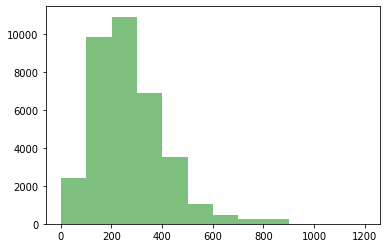

In [ ]:
### Context lengths

bin_size = 100
bins = range(1, max(context_lengths) + bin_size, bin_size)
plt.hist(context_lengths,
         bins,
         density=False,
         facecolor='g',
         alpha=0.5)
plt.show()

In [ ]:
bins = range(0, max(context_lengths) + bin_size, bin_size)
df = pd.DataFrame({'context_lengths': context_lengths})
df['bin'] = pd.cut(df.context_lengths, bins)
df.bin.value_counts().sort_index()

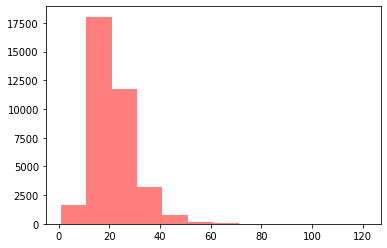

In [ ]:
### Question lengths

bin_size = 10
bins = range(1, max(question_lengths) + bin_size, bin_size)
plt.hist(question_lengths,
        bins,
        density=False,
        facecolor='r',
        alpha=0.5)
plt.show()

In [ ]:
bins = range(0, max(question_lengths) + bin_size, bin_size)
df = pd.DataFrame({'question_lengths': question_lengths})
df['bin'] = pd.cut(df.question_lengths, bins)
df.bin.value_counts().sort_index()

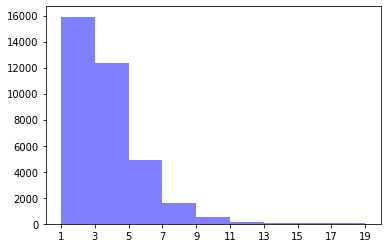

In [ ]:
### Answer lengths

bin_size = 2
bins = range(1, max(answer_lengths) + bin_size, bin_size)
plt.hist([a for a in answer_lengths if a <= 20],
         bins[:10],
         density=False,
         facecolor='b',
         alpha=0.5)
plt.xticks(bins[:10])
plt.show()

In [ ]:
bins = range(0, max(answer_lengths) + bin_size, bin_size)

df = pd.DataFrame({'answer_lengths': answer_lengths})
df['bin'] = pd.cut(df.answer_lengths, bins)
df.bin.value_counts()

### Performance by question/answer types and answer_lengths

In [ ]:
dev_answer_lengths = []
for datum in jaquad['validation']:
    answer = tokenizer(datum['answers.text'])['input_ids']
    dev_answer_lengths.append(len(answer) - 2)

In [ ]:
df = pd.DataFrame({
    'question_type': jaquad['validation']['question_type'],
    'answer_type': [typ[0] for typ in jaquad['validation']['answers.answer_type']],
    'answer_len': dev_answer_lengths,
    'f1': f1_scores,
    'em': em,
})

In [ ]:
df[['question_type', 'f1', 'em']].groupby(by='question_type').mean()

In [ ]:
df[['answer_type', 'f1', 'em']].groupby(by='answer_type').mean()

In [ ]:
bins = 2

df['answer_len_bin'] = (df['answer_len']-1) // bins * bins
df['answer_len_bin'][df.answer_len_bin >= 8] = 8
df['answer_len_bin'] = df['answer_len_bin'].apply(lambda x: f'{x+1:02d}-{x+bins:02d}')
df[['answer_len_bin', 'f1', 'em']].groupby(by='answer_len_bin').mean()